## GeometricErrors - Point Shifting 

For KDD 2021

### Part 1: Loading Data

In [1]:
""" Environment Configuration """

# Source of input tensors. 
data_path = '/data/GeometricErrors/EM'

# Source of original rasters, shapefiles.
source_path ='/data/GeometricErrors/Scene01'

# Label of dataset used (Original = 1, New = 2)
dataset_label = 1

# Path to save EM Test as folder
out_root_dir = '/data/GeometricErrors/tests'

# Enables training with GPU
use_gpu = True
gpus = ['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3']

# Environment Seeds
tf_seed = 2001 # Tensorflow
np_seed = 2001 # Numpy
py_seed = 2001 # Python

# Pre-Load Determiner.
preload = False
#   ^^^
# - True, the candidates are loaded and stored. 
# - False, the candidates are loaded from jupyter persistent storage




# Weights to load when skipping training
std_weight_path = '/data/GeometricErrors/tests/BaselineWeights.h5'


""" Point Shifting Annotator Configuration """

# number of points to generate on BOTH sides of each source point
pairs = 15

# Interval at which shifting vertices are sampled in meters
interval = 10

# Offset distance between coordinate points as they are generated on either side of the source. (meters)
off_dist = 1.5

# Minimum Valid Proability over map
min_probability = 1e-06

# Weight consideration candidate0 line distance between candidate points
length_weight_value = 0

# Buffer in meters to apply to candidates
weight_buffer = 2

buff_dist = 4
# Option to normalize over K^2 (True) or by K (False).
normalize_full = False


""" UNET Config """

# Base learning rate to use in training. Reccomend 0.01
learning_rate = 0.05




""" EM Iteration Config """

# Initial jump-start predicted class map path
seg_class_map_fp = '/data/pmap.tif'

# Number of EM iterations
em_target = 6


# Learning Rate Scheduler
import lib.K_Tools as kt 
lr_schedule = kt.Oscillate_LR

# Optionally Enable notes
prompt_notes = False


/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Std Imports
import os, sys, time, random, csv
from datetime import datetime as dt 

# Module Imports
import tensorflow as tf
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as shp
from tensorflow.keras.optimizers import Adam

# Lib imports
import lib.Doc_Tools as doc
import lib.GeoTools as gt
import lib.Tiling as tile
import lib.K_Tools as kt
from lib.Annotators import *

""" Static Configuration """
# Batch size for training
batch_size = 32
# Early Stopping Patience
es_patience = 20
# Reduce Learning Rate on Plateau: Multiplier to reduce LR by upon plateau
rlop_factor = 0.5
# Adam Optimizer config
adam_epsilon = 1e-8
adam_decay = 1e-5
# Buffer in meters applied to annotations when comparing iou
iou_buffer = 6

# Seed environment
random.seed(py_seed)
tf.random.set_seed(tf_seed)
np.random.seed(np_seed)

# Prompt for notes on test
if prompt_notes:
    test_notes = input("Enter Notes for test: ")
else:
    test_notes = 'Notes have been disabled.'
    
### Create Folder for test documentation
test_idx, test_dir = doc.InitTest(out_root_dir,
                                  em_target=em_target,
                                  LR=learning_rate,
                                  notes=test_notes,
                                  pairs=pairs,
                                  interval=interval,
                                  off_distance=off_dist,
                                  min_p=min_probability,
                                  L=length_weight_value)

### Loading Source
train_raster = rio.open('{}/train_raster.tif'.format(source_path))
test_raster = rio.open('{}/test_raster.tif'.format(source_path))
template_raster = rio.open('{}/template_map.tif'.format(source_path))

gt_labels = gpd.read_file('{}/GroundTruth.shp'.format(source_path))
imp_labels = gpd.read_file('{}/imperfectLines.shp'.format(source_path))

### Loading Tensors
X_train = np.load('{}/X_train.npy'.format(data_path))
Y_train = np.load('{}/Y_train.npy'.format(data_path))

X_val = np.load('{}/X_val.npy'.format(data_path))
Y_val = np.load('{}/Y_val.npy'.format(data_path))

X_test = np.load('{}/X_test.npy'.format(data_path))
Y_test = np.load('{}/Y_test.npy'.format(data_path))


### Loading tile offsets
train_offsets_fp = '{}/train_offsets.csv'.format(data_path)
val_offsets_fp = '{}/val_offsets.csv'.format(data_path)
print("Successfully loaded tensors.")

# Convert All CRS's
imp_labels = imp_labels.to_crs(train_raster.crs)
gt_labels = gt_labels.to_crs(imp_labels.crs)
source_annotation = imp_labels

### Evaluate original Shapefile Precision
source_iou = gt.gdf_iou(gt_labels, imp_labels, iou_buffer)
prev_iou = source_iou

### Create A distributed training strategy for GPU training
if use_gpu:
    mirror_strategy = tf.distribute.MirroredStrategy(devices=gpus)

Successfully loaded tensors.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [3]:
weight_buffer = 4

### Part 1: Baseline Model Training and Evaluation


Preparing UNET model...
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0'

Epoch 28/50
88/88 [==============================] - 11s 130ms/step - loss: -0.3559 - accuracy: 0.9330 - dice_coef: 0.3553 - f1_score: 0.3552 - val_loss: -0.1965 - val_accuracy: 0.9286 - val_dice_coef: 0.1965 - val_f1_score: 0.1962 - lr: 0.0063
Epoch 29/50
88/88 [==============================] - 11s 130ms/step - loss: -0.3633 - accuracy: 0.9334 - dice_coef: 0.3621 - f1_score: 0.3621 - val_loss: -0.1925 - val_accuracy: 0.9295 - val_dice_coef: 0.1925 - val_f1_score: 0.1921 - lr: 0.0063
Epoch 30/50
88/88 [==============================] - 11s 130ms/step - loss: -0.3603 - accuracy: 0.9330 - dice_coef: 0.3583 - f1_score: 0.3583 - val_loss: -0.1916 - val_accuracy: 0.9315 - val_dice_coef: 0.1916 - val_f1_score: 0.1909 - lr: 0.0063


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Baseline Preformance:
Training Report 00
 - F1_Score: 39.090
 - Dice_Score: 39.081
 - False_Positives: 126046000.000
 - False_Negatives: 723927500.000
 - Precision: 35.082
 - Recall: 44.133
 - Keras_Precision: 50.187
 - Keras_Recall: 14.924
Validation Report 00
 - F1_Score: 31.095
 - Dice_Score: 31.095
 - False_Positives: 7359100.000
 - False_Negatives: 45709600.000
 - Precision: 29.906
 - Recall: 32.384
 - Keras_Precision: 44.640
 - Keras_Recall: 11.490
Testing Report 00
 - F1_Score: 43.883
 - Dice_Score: 43.879
 - False_Positives: 10908300.000
 - False_Negatives: 6798800.000
 - Precision: 38.827
 - Recall: 50.454
 - Keras_Precision: 38.827
 - Keras_Recall: 50.454
 - Confusion Matrix: [[9788894  109083]
 [  67988   69235]]



Fri at 11:51:02PM


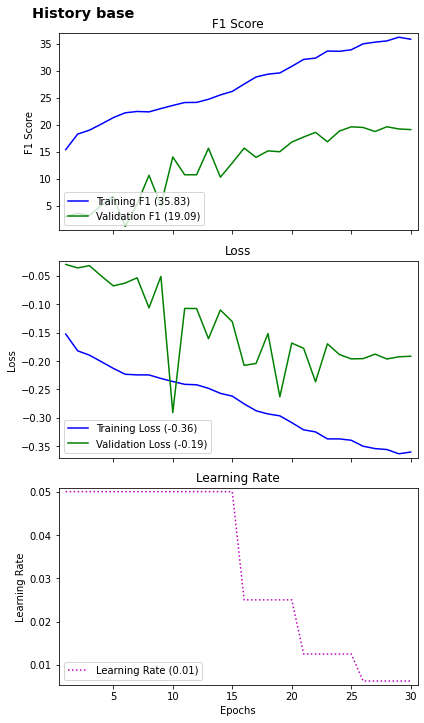

In [4]:
### Baseline Model Training
epochs = 50

# Get timer for baseline training
base_start = time.perf_counter()

# Prepare Baseline Folder
base_folder = os.path.join(test_dir, 'baseline')
if not os.path.exists(base_folder): os.mkdir(base_folder)

# Prepare tensorboard folder
base_tb_dir = os.path.join(base_folder, 'tensorboard')
    
# Prepare Callbacks, including weight output
base_callbacks = kt.SetCallbacks(weights_out=base_folder+'/BaselineWeights.h5', es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path=base_tb_dir)
metrics = [kt.dice_coef,'accuracy', kt.f1_score]
    
if use_gpu:
    with mirror_strategy.scope():
        # Select and Build Model
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

        # Train Model
        baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)
else:
    # Select and Build Model
    model = kt.Get_Model('UNET')
    model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

    # Train Model
    baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)

# Save History plot and csv
doc.plot_history(baseline_results, test_dir=base_folder, config_idx='base')

epochs_used = len(baseline_results.history['accuracy'])

    
""" Evaluate Baseline Model Preformance """
print("Baseline Preformance:")
train_rpt = kt.ModelReport(X_train, Y_train, model, 'Training')
val_rpt = kt.ModelReport(X_val, Y_val, model, 'Validation')
test_rpt = kt.ModelReport(X_test, Y_test, model, 'Testing')

print(dt.now().strftime('\n\n%a at %I:%M:%S%p'))


### Part 2: EM Iteration

`Warning`: By proceeding, the EM Iteration will use the model configured above with the parameters already set. Tune the baseline model above as many times as needed before proceeding.

#### Section 1: Configure EM Test with Annotator

In [5]:
seg_class_map_fp = None
preload = False

In [6]:
# Prepare annotator
annotator = Dynamic_Preloading_Annotator(pairs=pairs,                   # Number of pairs to be linearly generated on either side of the source point 
                                         off_dist=off_dist,             # Interval distance that each new pair is generated
                                         interval=interval,             # Inteval at which new candidate groups are generated
                                         min_p=min_probability,         # Minimum valid probability from class map
                                         L=length_weight_value,         # Weight for line distance
                                         weight_buffer=weight_buffer,   # Buffer to apply to candidates when weighting
                                         normalize_full=normalize_full, # Optionally normalize by K^2 instead of K
                                         )

#copy_anno = annotator

# Preload Candidate Data 
if preload:
    if seg_class_map_fp:
        initial_pmap = rio.open(seg_class_map_fp)
    else:
        initial_pmap = kt.Get_Pmap(source_raster=train_raster, pmodel=model, pmap_fp=None)
    print("PRELOADING")
    all_data = annotator.preload_candidates(source_annotation, initial_pmap)
    %store all_data
    #%store annotator
else:
    %store -r all_data
    #%store -r annotator
    
    # Check the annotators for equivalent configuration
    """bad_keys = []
    for key in ['pairs', 'off_dist', 'interval', 'min_p', 'L', 'weight_buffer', 'normalize_full']:
        if (getattr(annotator, key) != getattr(copy_anno, key)):
            bad_keys.append(key)
    if len(bad_keys) > 0:
        raise RuntimeError("Annotators have {} incompatible keys: {}\nCandidates must be regenerated. Configure this in the first block.".format(len(bad_keys),bad_keys))
    
    """
    print("Loaded candidate_data")
    
    
# Prepare performance storage
em_dict = {
    'Name': ['Base'],
    'Test_Data': [test_rpt],
    'Train_Data': [train_rpt],
    'Val_Data': [val_rpt],
    'Line_IoU': [np.round((source_iou*100), 2)],
    'Epochs': [epochs_used],
    'LR': [learning_rate],
    'Training_Time': ['{:.3f} s'.format(time.perf_counter() - base_start)],
    'Update_Time': ['NA'],
}

# Prepare EM iterator index.
EM_iterator = 0

# Prepare storage for top F1 and IoU
top_f1, top_f1_idx = 0, 0
top_iou, top_iou_idx = 0, 0


Loaded candidate_data


In [7]:
buff_dist = 4

#### Run EM Iteration

Beginning Iteration, Target steps: 6

EM Step 00 begun.
Sat at 12:07:25AM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 00)
Sat at 12:07:51AM

Created New Annotation. (Step 00)
Sat at 12:10:20AM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 00)
Sat at 12:10:25AM

New Learning Rate: 0.050000. (Step 00)
Preparing UNET model...
UNET model built successfully.

Training model...
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
Completed model Training. (Step 00)
Sat at 12:17:45AM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 01
 - F1_Score: 41.296
 - Dice_Score: 41.294
 - False_Positives: 28086200.000
 - False_Negatives: 2843300.000
 - Precision: 27.920
 - Recall: 79.280
 - Keras_Precision: 27.920
 - Keras_Recall: 79.280
 - Confusion Matrix: [[9617115  280862]
 [  28433  108790]]

Training Report 01
 - F1_Score: 51.021
 - Dice_Score: 51.019
 - False_Positives: 262315400.000
 - False_Negatives: 697704000.000
 - Precision: 41.484
 - Recall: 66.250
 - Keras_Precision: 55.519
 - Keras_Recall: 31.939
Validation Report 01
 - F1_Score: 36.682
 - Dice_Score: 36.675
 - False_Positives: 16808700.000
 - False_Negatives: 46750800.000
 - Precision: 31.201
 - Recall: 44.501
 - Keras_Precision: 47.131
 - Keras_Recall: 24.272

New Top F1: 41.30

New Top IoU: 19.07

EM Step (00) Complete on Sat at 12:18:11AM
- Annotation IoU:     19.07
	- Source Improvement: +0.81
	- Step Improvement:   +0.81

------ Times ---------------------
- Class Map Generation: 26.881 s
- Annotation Update:    139.910 s
- Model Traini

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 02
 - F1_Score: 50.121
 - Dice_Score: 50.120
 - False_Positives: 16284200.000
 - False_Negatives: 3687800.000
 - Precision: 38.127
 - Recall: 73.125
 - Keras_Precision: 38.127
 - Keras_Recall: 73.125
 - Confusion Matrix: [[9735135  162842]
 [  36878  100345]]

Training Report 02
 - F1_Score: 67.710
 - Dice_Score: 67.708
 - False_Positives: 122583800.000
 - False_Negatives: 702990800.000
 - Precision: 62.304
 - Recall: 74.143
 - Keras_Precision: 71.572
 - Keras_Recall: 30.508
Validation Report 02
 - F1_Score: 46.611
 - Dice_Score: 46.619
 - False_Positives: 9051300.000
 - False_Negatives: 48955000.000
 - Precision: 47.248
 - Recall: 45.991
 - Keras_Precision: 59.804
 - Keras_Recall: 21.573

New Top F1: 50.12

New Top IoU: 25.34

EM Step (01) Complete on Sat at 12:30:47AM
- Annotation IoU:     25.34
	- Source Improvement: +7.08
	- Step Improvement:   +6.27

------ Times ---------------------
- Class Map Generation: 24.723 s
- Annotation Update:    143.975 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 03
 - F1_Score: 50.958
 - Dice_Score: 50.961
 - False_Positives: 12427100.000
 - False_Negatives: 4781700.000
 - Precision: 41.842
 - Recall: 65.154
 - Keras_Precision: 41.842
 - Keras_Recall: 65.154
 - Confusion Matrix: [[9773706  124271]
 [  47817   89406]]

Training Report 03
 - F1_Score: 62.418
 - Dice_Score: 62.414
 - False_Positives: 117036500.000
 - False_Negatives: 737339000.000
 - Precision: 60.199
 - Recall: 64.806
 - Keras_Precision: 69.649
 - Keras_Recall: 26.699
Validation Report 03
 - F1_Score: 49.740
 - Dice_Score: 49.734
 - False_Positives: 6941200.000
 - False_Negatives: 49638400.000
 - Precision: 54.051
 - Recall: 46.067
 - Keras_Precision: 64.186
 - Keras_Recall: 20.039

New Top F1: 50.96

New Top IoU: 26.87

EM Step (02) Complete on Sat at 12:40:45AM
- Annotation IoU:     26.87
	- Source Improvement: +8.61
	- Step Improvement:   +1.53

------ Times ---------------------
- Class Map Generation: 27.320 s
- Annotation Update:    142.186 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 04
 - F1_Score: 54.263
 - Dice_Score: 54.267
 - False_Positives: 11849600.000
 - False_Negatives: 4201100.000
 - Precision: 44.552
 - Recall: 69.385
 - Keras_Precision: 44.552
 - Keras_Recall: 69.385
 - Confusion Matrix: [[9779481  118496]
 [  42011   95212]]

Training Report 04
 - F1_Score: 74.262
 - Dice_Score: 74.261
 - False_Positives: 74449500.000
 - False_Negatives: 711592400.000
 - Precision: 73.231
 - Recall: 75.321
 - Keras_Precision: 79.712
 - Keras_Recall: 29.132
Validation Report 04
 - F1_Score: 56.147
 - Dice_Score: 56.143
 - False_Positives: 5232700.000
 - False_Negatives: 48609400.000
 - Precision: 62.652
 - Recall: 50.865
 - Keras_Precision: 71.180
 - Keras_Recall: 21.003

New Top F1: 54.26

New Top IoU: 30.16

EM Step (03) Complete on Sat at 12:54:22AM
- Annotation IoU:     30.16
	- Source Improvement: +11.90
	- Step Improvement:   +3.29

------ Times ---------------------
- Class Map Generation: 24.674 s
- Annotation Update:    140.227 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 05
 - F1_Score: 52.573
 - Dice_Score: 52.567
 - False_Positives: 13642600.000
 - False_Negatives: 3963900.000
 - Precision: 41.701
 - Recall: 71.113
 - Keras_Precision: 41.701
 - Keras_Recall: 71.113
 - Confusion Matrix: [[9761551  136426]
 [  39639   97584]]

Training Report 05
 - F1_Score: 68.471
 - Dice_Score: 68.469
 - False_Positives: 116754600.000
 - False_Negatives: 703019700.000
 - Precision: 63.386
 - Recall: 74.443
 - Keras_Precision: 72.141
 - Keras_Recall: 30.072
Validation Report 05
 - F1_Score: 52.787
 - Dice_Score: 52.797
 - False_Positives: 8602200.000
 - False_Negatives: 47009700.000
 - Precision: 51.937
 - Recall: 53.665
 - Keras_Precision: 62.168
 - Keras_Recall: 23.118

New Top IoU: 30.39

EM Step (04) Complete on Sat at 01:03:52AM
- Annotation IoU:     30.39
	- Source Improvement: +12.13
	- Step Improvement:   +0.24

------ Times ---------------------
- Class Map Generation: 25.357 s
- Annotation Update:    141.165 s
- Model Training:       363.191 s

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 06
 - F1_Score: 58.401
 - Dice_Score: 58.402
 - False_Positives: 11923400.000
 - False_Negatives: 3144900.000
 - Precision: 47.009
 - Recall: 77.082
 - Keras_Precision: 47.009
 - Keras_Recall: 77.082
 - Confusion Matrix: [[9778743  119234]
 [  31449  105774]]

Training Report 06
 - F1_Score: 78.530
 - Dice_Score: 78.530
 - False_Positives: 58759200.000
 - False_Negatives: 707343600.000
 - Precision: 78.456
 - Recall: 78.605
 - Keras_Precision: 83.631
 - Keras_Recall: 29.795
Validation Report 06
 - F1_Score: 64.324
 - Dice_Score: 64.320
 - False_Positives: 4337700.000
 - False_Negatives: 47277700.000
 - Precision: 70.234
 - Recall: 59.330
 - Keras_Precision: 77.320
 - Keras_Recall: 23.826

New Top F1: 58.40

New Top IoU: 33.69

EM Step (05) Complete on Sat at 01:17:32AM
- Annotation IoU:     33.69
	- Source Improvement: +15.43
	- Step Improvement:   +3.30

------ Times ---------------------
- Class Map Generation: 24.686 s
- Annotation Update:    140.325 s
- Model Trainin

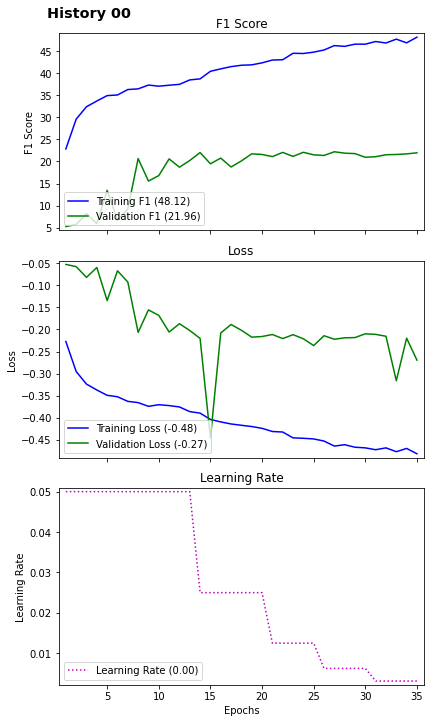

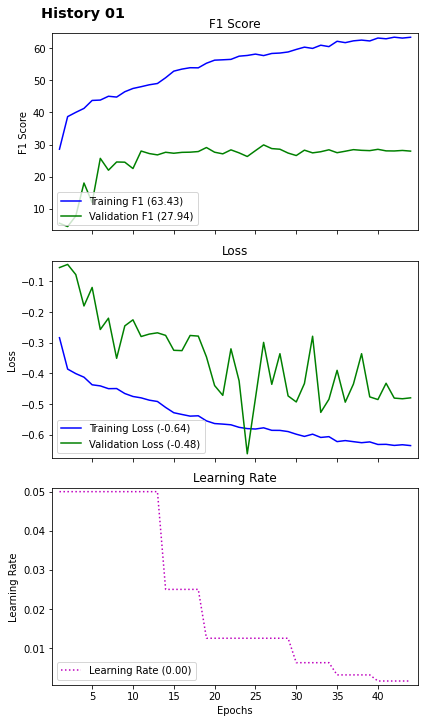

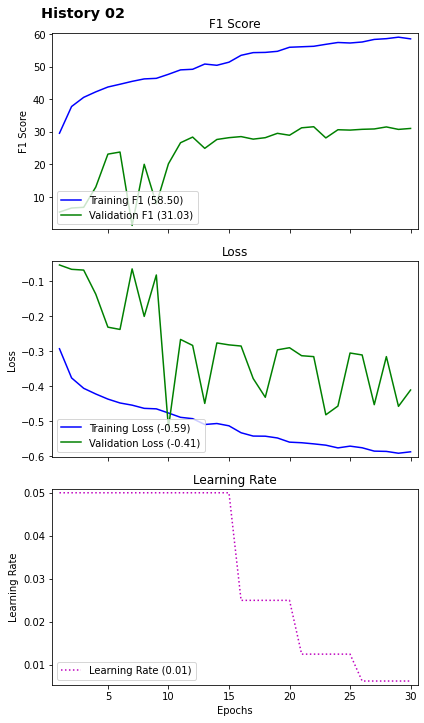

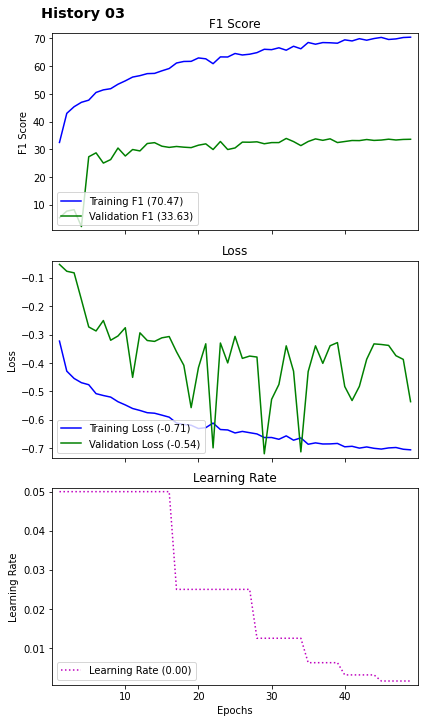

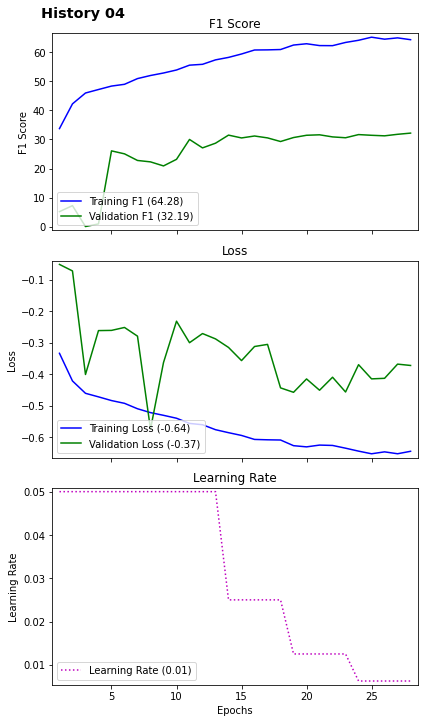

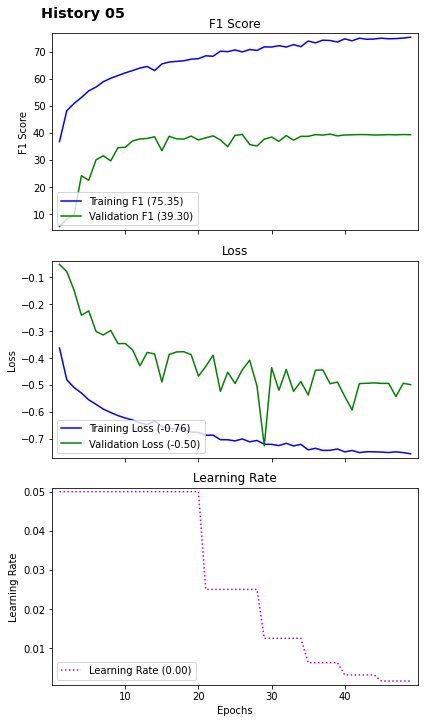

In [8]:
print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 10
Current Step: 6

EM Step 06 begun.
Sat at 12:11:54PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 06)
Sat at 12:12:18PM

Created New Annotation. (Step 06)
Sat at 12:14:47PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 06)
Sat at 12:14:52PM

New Learning Rate: 0.050000. (Step 06)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 06)
Sat at 12:22:45PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 07
 - F1_Score: 57.996
 - Dice_Score: 57.994
 - False_Positives: 3928600.000
 - False_Negatives: 6513500.000
 - Precision: 64.726
 - Recall: 52.533
 - Keras_Precision: 64.726
 - Keras_Recall: 52.533
 - Confusion Matrix: [[9858691   39286]
 [  65135   72088]]

Training Report 07
 - F1_Score: 68.812
 - Dice_Score: 68.811
 - False_Positives: 46002100.000
 - False_Negatives: 701332600.000
 - Precision: 69.476
 - Recall: 68.160
 - Keras_Precision: 76.924
 - Keras_Recall: 17.943
Validation Report 07
 - F1_Score: 51.970
 - Dice_Score: 51.976
 - False_Positives: 3595800.000
 - False_Negatives: 45531900.000
 - Precision: 57.059
 - Recall: 47.715
 - Keras_Precision: 66.634
 - Keras_Recall: 13.623

New Top IoU: 33.85

EM Step (06) Complete on Sat at 12:23:11PM
- Annotation IoU:     33.85
	- Source Improvement: +15.59
	- Step Improvement:   +0.16

------ Times ---------------------
- Class Map Generation: 24.535 s
- Annotation Update:    140.133 s
- Model Training:       473.355 s
-

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 08
 - F1_Score: 55.678
 - Dice_Score: 55.671
 - False_Positives: 3429200.000
 - False_Negatives: 7105500.000
 - Precision: 65.865
 - Recall: 48.219
 - Keras_Precision: 65.865
 - Keras_Recall: 48.219
 - Confusion Matrix: [[9863685   34292]
 [  71055   66168]]

Training Report 08
 - F1_Score: 70.703
 - Dice_Score: 70.696
 - False_Positives: 35010700.000
 - False_Negatives: 706673300.000
 - Precision: 74.879
 - Recall: 66.968
 - Keras_Precision: 80.611
 - Keras_Recall: 17.079
Validation Report 08
 - F1_Score: 59.993
 - Dice_Score: 59.991
 - False_Positives: 2364200.000
 - False_Negatives: 45169700.000
 - Precision: 69.095
 - Recall: 53.009
 - Keras_Precision: 76.221
 - Keras_Recall: 14.367

New Top IoU: 34.58

EM Step (07) Complete on Sat at 12:33:24PM
- Annotation IoU:     34.58
	- Source Improvement: +16.33
	- Step Improvement:   +0.73

------ Times ---------------------
- Class Map Generation: 24.858 s
- Annotation Update:    140.418 s
- Model Training:       408.526 s
-

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 09
 - F1_Score: 56.325
 - Dice_Score: 56.332
 - False_Positives: 3368300.000
 - False_Negatives: 7022200.000
 - Precision: 66.546
 - Recall: 48.826
 - Keras_Precision: 66.546
 - Keras_Recall: 48.826
 - Confusion Matrix: [[9864294   33683]
 [  70222   67001]]

Training Report 09
 - F1_Score: 72.152
 - Dice_Score: 72.148
 - False_Positives: 35539200.000
 - False_Negatives: 700106000.000
 - Precision: 75.116
 - Recall: 69.413
 - Keras_Precision: 80.892
 - Keras_Recall: 17.688
Validation Report 09
 - F1_Score: 64.592
 - Dice_Score: 64.591
 - False_Positives: 2352000.000
 - False_Negatives: 44186400.000
 - Precision: 71.365
 - Recall: 58.994
 - Keras_Precision: 77.723
 - Keras_Recall: 15.663

New Top IoU: 34.62

EM Step (08) Complete on Sat at 12:43:55PM
- Annotation IoU:     34.62
	- Source Improvement: +16.37
	- Step Improvement:   +0.04

------ Times ---------------------
- Class Map Generation: 24.447 s
- Annotation Update:    140.714 s
- Model Training:       424.741 s
-

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 10
 - F1_Score: 54.582
 - Dice_Score: 54.577
 - False_Positives: 3164800.000
 - False_Negatives: 7383800.000
 - Precision: 66.698
 - Recall: 46.191
 - Keras_Precision: 66.698
 - Keras_Recall: 46.191
 - Confusion Matrix: [[9866329   31648]
 [  73838   63385]]

Training Report 10
 - F1_Score: 73.727
 - Dice_Score: 73.726
 - False_Positives: 27741100.000
 - False_Negatives: 701157300.000
 - Precision: 79.155
 - Recall: 68.995
 - Keras_Precision: 84.182
 - Keras_Recall: 17.393
Validation Report 10
 - F1_Score: 63.714
 - Dice_Score: 63.707
 - False_Positives: 1918600.000
 - False_Negatives: 44580300.000
 - Precision: 73.796
 - Recall: 56.056
 - Keras_Precision: 80.104
 - Keras_Recall: 14.769

EM Step (09) Complete on Sat at 12:57:42PM
- Annotation IoU:     34.16
	- Source Improvement: +15.90
	- Step Improvement:   -0.46

------ Times ---------------------
- Class Map Generation: 24.376 s
- Annotation Update:    140.267 s
- Model Training:       624.169 s
- Model Evaluation:  

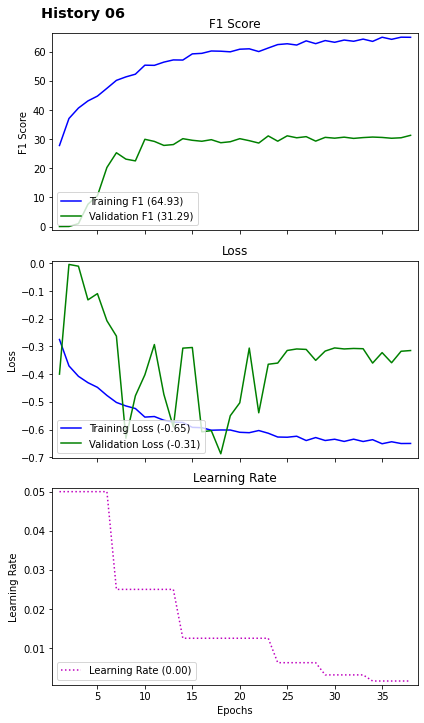

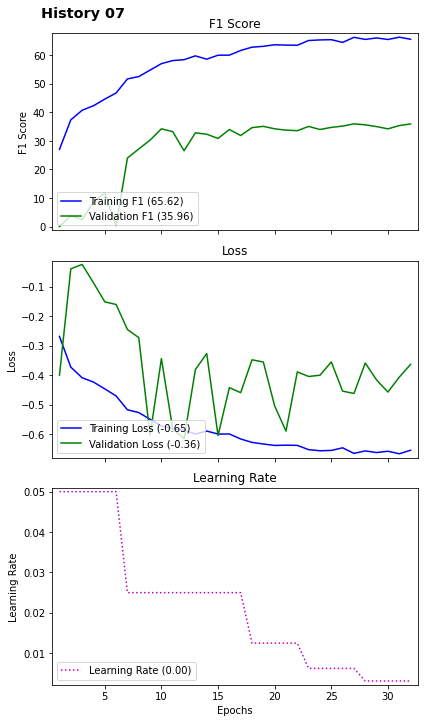

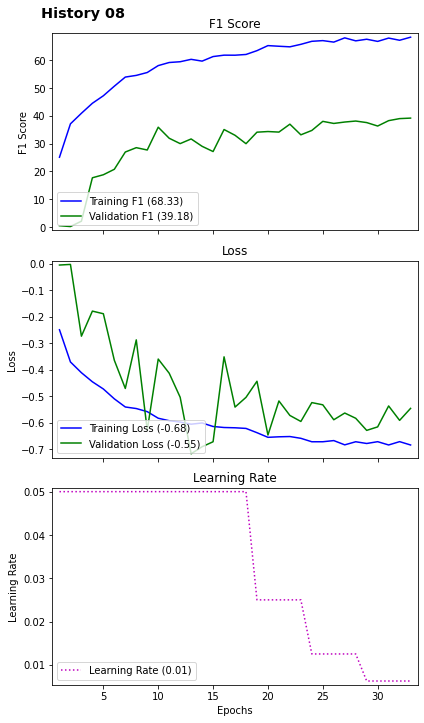

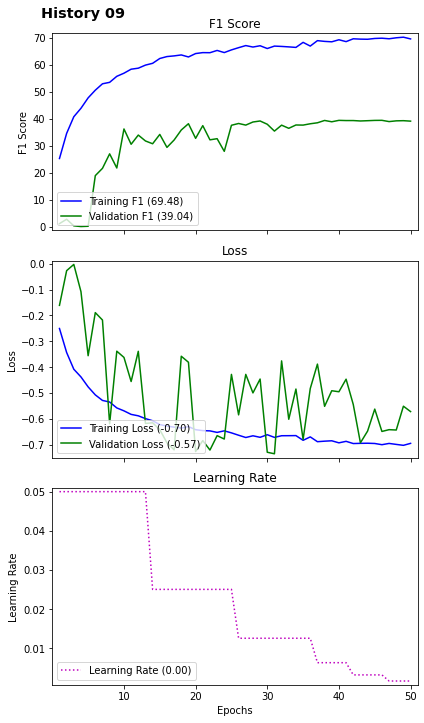

In [9]:
em_target = 10
buff_dist = 2

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 14
Current Step: 10

EM Step 10 begun.
Sat at 01:27:39PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 10)
Sat at 01:28:03PM

Created New Annotation. (Step 10)
Sat at 01:30:35PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 10)
Sat at 01:30:40PM

New Learning Rate: 0.050000. (Step 10)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 10)
Sat at 01:40:11PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 11
 - F1_Score: 56.952
 - Dice_Score: 56.950
 - False_Positives: 3110700.000
 - False_Negatives: 7020500.000
 - Precision: 68.299
 - Recall: 48.839
 - Keras_Precision: 68.299
 - Keras_Recall: 48.839
 - Confusion Matrix: [[9866870   31107]
 [  70205   67018]]

Training Report 11
 - F1_Score: 72.726
 - Dice_Score: 72.723
 - False_Positives: 28182600.000
 - False_Negatives: 702575300.000
 - Precision: 78.385
 - Recall: 67.829
 - Keras_Precision: 83.704
 - Keras_Recall: 17.084
Validation Report 11
 - F1_Score: 59.787
 - Dice_Score: 59.791
 - False_Positives: 1926700.000
 - False_Negatives: 45039900.000
 - Precision: 71.765
 - Recall: 51.235
 - Keras_Precision: 78.657
 - Keras_Recall: 13.618

EM Step (10) Complete on Sat at 01:40:37PM
- Annotation IoU:     33.58
	- Source Improvement: +15.32
	- Step Improvement:   -0.59

------ Times ---------------------
- Class Map Generation: 24.821 s
- Annotation Update:    142.675 s
- Model Training:       571.397 s
- Model Evaluation:  

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 12
 - F1_Score: 55.120
 - Dice_Score: 55.120
 - False_Positives: 3449300.000
 - False_Negatives: 7189300.000
 - Precision: 65.446
 - Recall: 47.609
 - Keras_Precision: 65.446
 - Keras_Recall: 47.609
 - Confusion Matrix: [[9863484   34493]
 [  71893   65330]]

Training Report 12
 - F1_Score: 73.119
 - Dice_Score: 73.116
 - False_Positives: 27885500.000
 - False_Negatives: 701429900.000
 - Precision: 78.826
 - Recall: 68.182
 - Keras_Precision: 83.885
 - Keras_Recall: 17.146
Validation Report 12
 - F1_Score: 54.055
 - Dice_Score: 54.056
 - False_Positives: 2278900.000
 - False_Negatives: 45679600.000
 - Precision: 65.996
 - Recall: 45.773
 - Keras_Precision: 73.958
 - Keras_Recall: 12.410

EM Step (11) Complete on Sat at 01:54:15PM
- Annotation IoU:     33.19
	- Source Improvement: +14.93
	- Step Improvement:   -0.39

------ Times ---------------------
- Class Map Generation: 24.359 s
- Annotation Update:    140.665 s
- Model Training:       612.518 s
- Model Evaluation:  

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 13
 - F1_Score: 56.518
 - Dice_Score: 56.511
 - False_Positives: 3888900.000
 - False_Negatives: 6785200.000
 - Precision: 64.078
 - Recall: 50.553
 - Keras_Precision: 64.078
 - Keras_Recall: 50.553
 - Confusion Matrix: [[9859088   38889]
 [  67852   69371]]

Training Report 13
 - F1_Score: 70.740
 - Dice_Score: 70.736
 - False_Positives: 31309700.000
 - False_Negatives: 704898500.000
 - Precision: 76.245
 - Recall: 65.976
 - Keras_Precision: 81.890
 - Keras_Recall: 16.725
Validation Report 13
 - F1_Score: 54.727
 - Dice_Score: 54.724
 - False_Positives: 2332700.000
 - False_Negatives: 45476100.000
 - Precision: 65.845
 - Recall: 46.822
 - Keras_Precision: 73.872
 - Keras_Recall: 12.666

EM Step (12) Complete on Sat at 02:05:34PM
- Annotation IoU:     32.28
	- Source Improvement: +14.02
	- Step Improvement:   -0.91

------ Times ---------------------
- Class Map Generation: 25.202 s
- Annotation Update:    142.405 s
- Model Training:       467.214 s
- Model Evaluation:  

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 14
 - F1_Score: 57.812
 - Dice_Score: 57.810
 - False_Positives: 3926800.000
 - False_Negatives: 6546300.000
 - Precision: 64.632
 - Recall: 52.294
 - Keras_Precision: 64.632
 - Keras_Recall: 52.294
 - Confusion Matrix: [[9858709   39268]
 [  65463   71760]]

Training Report 14
 - F1_Score: 70.051
 - Dice_Score: 70.050
 - False_Positives: 36806400.000
 - False_Negatives: 700331500.000
 - Precision: 73.518
 - Recall: 66.897
 - Keras_Precision: 79.785
 - Keras_Recall: 17.179
Validation Report 14
 - F1_Score: 53.041
 - Dice_Score: 53.038
 - False_Positives: 2648300.000
 - False_Negatives: 45416900.000
 - Precision: 62.793
 - Recall: 45.910
 - Keras_Precision: 71.472
 - Keras_Recall: 12.746

EM Step (13) Complete on Sat at 02:16:57PM
- Annotation IoU:     32.17
	- Source Improvement: +13.91
	- Step Improvement:   -0.11

------ Times ---------------------
- Class Map Generation: 26.292 s
- Annotation Update:    140.896 s
- Model Training:       472.348 s
- Model Evaluation:  

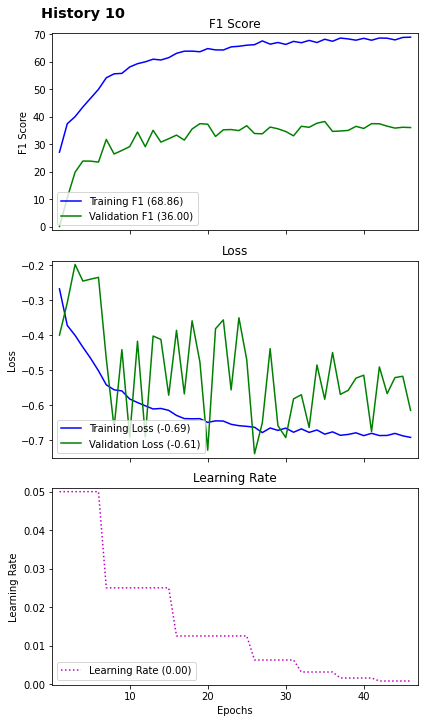

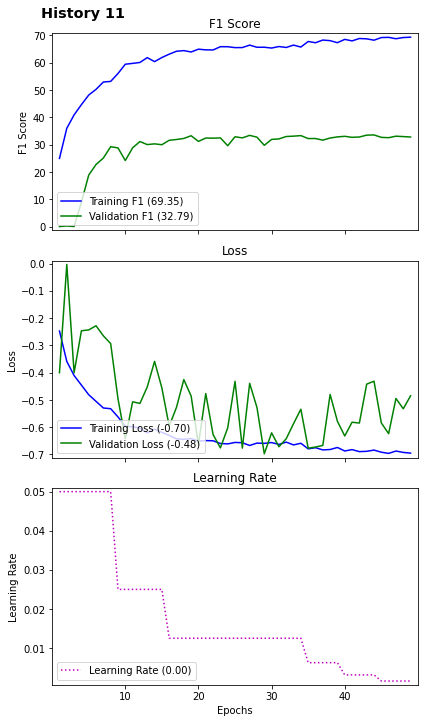

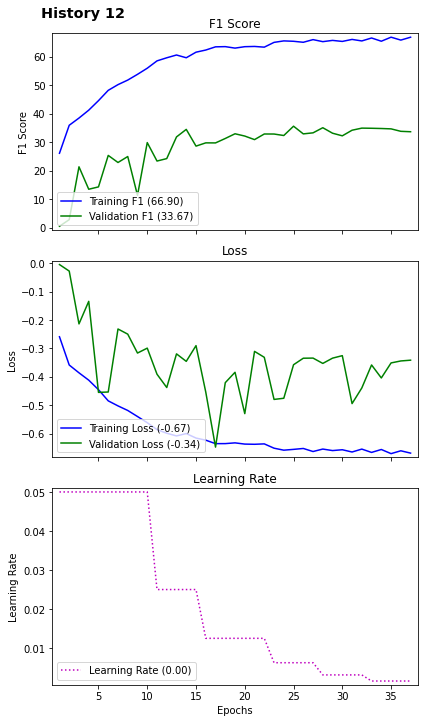

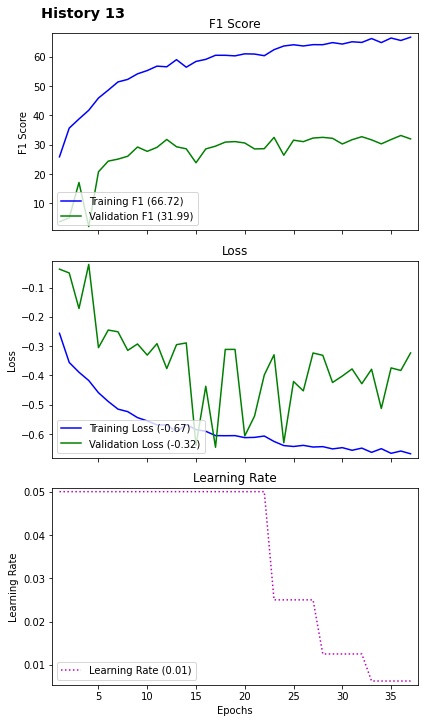

In [10]:
buff_dist = 2

em_target = 14

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1

### Create Plots

/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


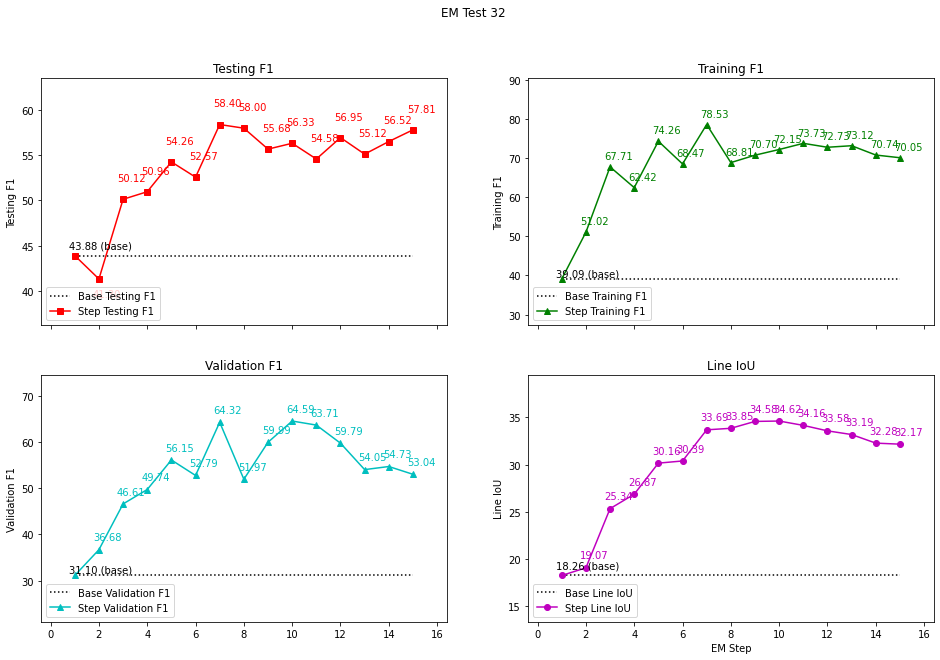

In [11]:
# Clean data for easy indexing

## Converts each of the report lists into a dict of lists for each value
model_dict = {'Test_Data': {}, 'Train_Data': {}, 'Val_Data': {}}
for em_key in model_dict.keys():
    for report in em_dict[em_key]:
        for rpt_key, rpt_value in [(key, item) for key, item in report.items()]:
            if rpt_key not in model_dict[em_key].keys():
                model_dict[em_key].update({rpt_key: np.array([rpt_value])})
            else:
                model_dict[em_key][rpt_key] = np.append(model_dict[em_key][rpt_key], report[rpt_key])


# Create Figure for Plots
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(16,10))

## Plot Testing F1
doc.plot_axis(ax=axs[0,0], 
              data=model_dict['Test_Data']['F1_Score']*100, 
              name='Testing F1', 
              color_char='r', 
              symbol_char='s', 
              y_off=2,
              label_delta=False)

## Plot Training F1
doc.plot_axis(ax=axs[0,1], 
              data=model_dict['Train_Data']['F1_Score']*100, 
              name='Training F1', 
              color_char='g', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Validation F1
doc.plot_axis(ax=axs[1,0], 
              data=model_dict['Val_Data']['F1_Score']*100, 
              name='Validation F1', 
              color_char='c', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Annotation IoU
doc.plot_axis(ax=axs[1,1], 
              data=em_dict['Line_IoU'], 
              name='Line IoU', 
              color_char='m', 
              x_label='EM Step',
              label_delta=False)
    
## Title and show, and save figure
fig.suptitle("EM Test {:02}".format(test_idx))
fig_path = os.path.join(test_dir, 'test_{:02}_plot.png'.format(test_idx))
fig.savefig(fig_path)
fig.show()


### Save to Markdown

Saves:
- Annotator Config
- Model Config
- EM preformance table
- Model preformance table

In [ ]:
### Write test data to markdown
markdown_fp = os.path.join(test_dir, 'em_test_info_{:02}.md'.format(test_idx))
md = open(markdown_fp, 'w+')

# Header / Notes
md.write("# EM Test {:02}\n\n".format(test_idx))

if (len(test_notes) > 0):
    md.write("### Notes: \n")
    md.write(test_notes)

md.write(dt.now().strftime('\n%a at %I:%M:%S%p'))
    
md.write("\n\n---\n\n")

# prepare peak values
top_f1 = np.round((top_f1*100), 3)
source_f1 = np.round((em_dict['Test_Data'][0]['F1_Score']*100), 3)
source_iou = np.round(source_iou*100, 2)

# Note at top the peak values 
md.write("### Top Values:\n\n")
md.write(" - Testing F1 Score: **{:.2f}** (`{:+.2f}`) - Step {:02}\n".format(top_f1, (top_f1-source_f1), top_f1_idx))
md.write(" - Annotation IoU: **{:.2f}** (`{:+.2f}`) - Step {:02}\n\n\n".format(top_iou, (top_iou-source_iou), top_iou_idx))



# Test Configuration Section
md.write("## **Test Config**\n\n")

md.write("### Seeds:\n")
md.write("`Python`: {}, `Numpy`: {}, `Tensorflow`: {}\n\n".format(py_seed, np_seed, tf_seed))

md.write("### Annotator:\n")
for key, item in annotator.__dict__.items():
    
    # Skip gross keys
    if key in ['verbosity', 'crop_window', 'class_map', 'kwargs_key', 'crs']:
        continue
    
    # Write key and item
    md.write("- `{}`: {}\n".format(key, item))
        
md.write("\n\n")

md.write("### Model:\n")
md.write("- **Training**:\n")
md.write("  - `Batch Size`: {}\n".format(batch_size))
md.write("  - `Learning Rate`: {}\n".format(learning_rate))
md.write("  - `Epochs`: {}\n".format(epochs))
md.write("- **Callbacks**:\n")
md.write("  - `ES Patience`: {}\n".format(es_patience))
md.write("  - `RLOP Factor`: {}\n".format(rlop_factor))
md.write("  - `Adam Epsilon`: {}\n".format(adam_epsilon))
md.write("  - `Adam Decay`: {}\n".format(adam_decay))

md.write("\n\n")

md.write("### Other:\n")
md.write("- EM Steps: {}\n".format(em_target))
md.write("- ClassMap: '{}'\n".format(seg_class_map_fp))


md.write("\n---\n\n")


# Results Section

md.write("## **Results**:\n\n")

md.write("### EM Iteration:\n\n")

md.write("Step | Anno IoU | F1 | Epochs | LR | Train | Update\n")
md.write("---- | -------- | -- | ------ | -- | ----- | ------\n")
for idx in range(em_target):
    if idx == 0:
        md.write("{} | {} | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))
    else:
        md.write("{} | {} (`{:+.2f}`) | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], (em_dict['Line_IoU'][idx] - em_dict['Line_IoU'][0]), em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))

md.write("\n\n</br>\n\n")
    
md.write("### Model Performance:\n\n")
md.write("Step | Test F1 | Test (FP, FN) | Train F1 | Train (FP, FN) | Val F1 | Val (FP, FN) | LR \n")
md.write("---- | ------- | ------------- | -------- | -------------- | ------ | ------------ | -- \n")
for idx in range(em_target):
    # Create a string to hold this row's data
    row_string = "{} | ".format(em_dict['Name'][idx])
    
    # Iterate over F1 types
    for key in ['Test_Data', 'Train_Data', 'Val_Data']:
        
        if idx == 0:
            row_string += "{:.2f} | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
        else:
            row_string += "{:.2f} (`{:+.2f}`) | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, (em_dict[key][idx]['F1_Score']*100 - em_dict[key][0]['F1_Score']*100), em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
      
    # After all sets have been added, append learning rate and newline
    row_string += "{}\n".format(em_dict['LR'][idx])
    md.write(row_string)


# Close Markdown
md.close()

print("Config and results written to markdown.")
print("Location:", markdown_fp)